## Content
1. [Load data](#1.-Load-data)  
2. [Diving into data](#2.-Diving-into-data)  
3. [Training word2vec model](#3.-Training-word2vec-model)  

In [1]:
import numpy as np
import pandas as pd

from pprint import pprint

IN_PATH = '../data/'
WORD_EMBEDDINGS_PATH = '../word_embeddings/'
MAX_NR_OF_COMMENTS = None
target_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

## 1. Load data

In [2]:
train_df = pd.read_csv(IN_PATH + 'train.csv', encoding='utf8')
test_df = pd.read_csv(IN_PATH + 'test.csv', encoding='utf8')

In [3]:
if MAX_NR_OF_COMMENTS is not None:
    print('MAX_NR_OF_COMMENTS: {}'.format(MAX_NR_OF_COMMENTS))
    train_df = train_df.head(MAX_NR_OF_COMMENTS)
    test_df = test_df.head(MAX_NR_OF_COMMENTS)

## 2. Diving into data

### General info

In [4]:
print(train_df[0:5])

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [5]:
comment = train_df['comment_text'][0]
print(comment)

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [6]:
print(type(comment))

<type 'unicode'>


In [7]:
print(train_df.shape)
print(test_df.shape)

(159571, 8)
(153164, 2)


### Data distribution

In [8]:
def comments_lengths_char(df):
    return [len(comment) for comment in df['comment_text']]

In [9]:
train_comments_lengths_chars = comments_lengths_char(train_df)
test_comments_lengths_chars = comments_lengths_char(test_df)

In [10]:
from nltk.tokenize import WordPunctTokenizer
word_punct_tokenizer = WordPunctTokenizer()

def comments_lengths_words(df):
    lengths = list()
    words = list()
    n = 0
    
    for comment in df['comment_text']:
        words.append([])
        comment_length = 0
        
        for word in word_punct_tokenizer.tokenize(comment):
            if word.isalpha():
                comment_length += 1
                words[n].append(word)
                
        lengths.append(comment_length)
        n += 1
        
    return (lengths, words)

In [11]:
(train_comments_lengths_words, train_comment_words) = comments_lengths_words(train_df)
(test_comments_lengths_words, test_comment_words) = comments_lengths_words(test_df)

In [12]:
comment_0_words = word_punct_tokenizer.tokenize(train_df['comment_text'][0])
filtered_comment_0_words = train_comment_words[0]

print(comment_0_words)
print(filtered_comment_0_words)

[u'Explanation', u'Why', u'the', u'edits', u'made', u'under', u'my', u'username', u'Hardcore', u'Metallica', u'Fan', u'were', u'reverted', u'?', u'They', u'weren', u"'", u't', u'vandalisms', u',', u'just', u'closure', u'on', u'some', u'GAs', u'after', u'I', u'voted', u'at', u'New', u'York', u'Dolls', u'FAC', u'.', u'And', u'please', u'don', u"'", u't', u'remove', u'the', u'template', u'from', u'the', u'talk', u'page', u'since', u'I', u"'", u'm', u'retired', u'now', u'.', u'89', u'.', u'205', u'.', u'38', u'.', u'27']
[u'Explanation', u'Why', u'the', u'edits', u'made', u'under', u'my', u'username', u'Hardcore', u'Metallica', u'Fan', u'were', u'reverted', u'They', u'weren', u't', u'vandalisms', u'just', u'closure', u'on', u'some', u'GAs', u'after', u'I', u'voted', u'at', u'New', u'York', u'Dolls', u'FAC', u'And', u'please', u'don', u't', u'remove', u'the', u'template', u'from', u'the', u'talk', u'page', u'since', u'I', u'm', u'retired', u'now']


In [13]:
def show_hists(x_train, x_test, values_name=''):
    fig, axs = plt.subplots(1, 2)
    plt.subplots_adjust(wspace=0.4)
    
    axs[0].hist(x_train)
    axs[0].set_xlabel('number of ' + values_name)
    axs[0].set_ylabel('frequency')
    axs[0].set_title('train set')
    
    axs[1].hist(x_test)
    axs[1].set_xlabel('number of ' + values_name)
    axs[1].set_ylabel('frequency')
    axs[1].set_title('test set')

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

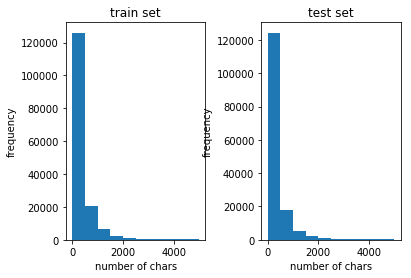

In [15]:
show_hists(train_comments_lengths_chars, test_comments_lengths_chars, 'chars')

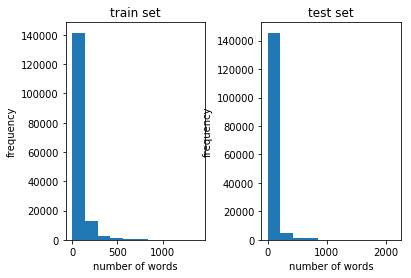

In [16]:
show_hists(train_comments_lengths_words, test_comments_lengths_words, 'words')

## 3. Training word2vec model
A good tutorial can be found here: https://rare-technologies.com/word2vec-tutorial/  
Good link: https://radimrehurek.com/gensim/models/word2vec.html

In [17]:
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [18]:
model_sg = 1
model_size = 200
model_min_count = 2
model_negative = 10
model_window = 10

In [19]:
model = gensim.models.Word2Vec(train_comment_words + test_comment_words, sg=model_sg, size=model_size, 
                               min_count=model_min_count,
                               negative=model_negative, window=model_window,
                               workers=5)

2018-05-16 02:09:37,479 : INFO : collecting all words and their counts
2018-05-16 02:09:37,480 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-05-16 02:09:37,609 : INFO : PROGRESS: at sentence #10000, processed 688925 words, keeping 42375 word types
2018-05-16 02:09:37,732 : INFO : PROGRESS: at sentence #20000, processed 1366359 words, keeping 63569 word types
2018-05-16 02:09:37,870 : INFO : PROGRESS: at sentence #30000, processed 2030874 words, keeping 80498 word types
2018-05-16 02:09:38,001 : INFO : PROGRESS: at sentence #40000, processed 2720130 words, keeping 95520 word types
2018-05-16 02:09:38,138 : INFO : PROGRESS: at sentence #50000, processed 3388878 words, keeping 108511 word types
2018-05-16 02:09:38,286 : INFO : PROGRESS: at sentence #60000, processed 4092316 words, keeping 121111 word types
2018-05-16 02:09:38,420 : INFO : PROGRESS: at sentence #70000, processed 4773127 words, keeping 132764 word types
2018-05-16 02:09:38,561 : INFO : PROG

2018-05-16 02:10:19,151 : INFO : EPOCH 1 - PROGRESS: at 21.52% examples, 105398 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:10:20,161 : INFO : EPOCH 1 - PROGRESS: at 22.30% examples, 105892 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:10:21,216 : INFO : EPOCH 1 - PROGRESS: at 22.96% examples, 105811 words/s, in_qsize 9, out_qsize 0
2018-05-16 02:10:22,295 : INFO : EPOCH 1 - PROGRESS: at 23.73% examples, 106054 words/s, in_qsize 9, out_qsize 0
2018-05-16 02:10:23,308 : INFO : EPOCH 1 - PROGRESS: at 24.35% examples, 106056 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:10:24,372 : INFO : EPOCH 1 - PROGRESS: at 25.08% examples, 106346 words/s, in_qsize 9, out_qsize 0
2018-05-16 02:10:25,416 : INFO : EPOCH 1 - PROGRESS: at 25.78% examples, 106453 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:10:26,645 : INFO : EPOCH 1 - PROGRESS: at 26.56% examples, 106295 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:10:27,704 : INFO : EPOCH 1 - PROGRESS: at 27.32% examples, 106541 words/s, in

2018-05-16 02:11:36,752 : INFO : EPOCH 1 - PROGRESS: at 71.08% examples, 102760 words/s, in_qsize 10, out_qsize 1
2018-05-16 02:11:37,913 : INFO : EPOCH 1 - PROGRESS: at 71.89% examples, 102809 words/s, in_qsize 9, out_qsize 0
2018-05-16 02:11:38,931 : INFO : EPOCH 1 - PROGRESS: at 72.65% examples, 102906 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:11:40,178 : INFO : EPOCH 1 - PROGRESS: at 73.56% examples, 102935 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:11:41,238 : INFO : EPOCH 1 - PROGRESS: at 74.44% examples, 103127 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:11:42,349 : INFO : EPOCH 1 - PROGRESS: at 75.12% examples, 103088 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:11:43,406 : INFO : EPOCH 1 - PROGRESS: at 75.90% examples, 103147 words/s, in_qsize 9, out_qsize 0
2018-05-16 02:11:44,452 : INFO : EPOCH 1 - PROGRESS: at 76.69% examples, 103225 words/s, in_qsize 10, out_qsize 1
2018-05-16 02:11:45,573 : INFO : EPOCH 1 - PROGRESS: at 77.51% examples, 103302 words/s, i

2018-05-16 02:12:50,593 : INFO : EPOCH 2 - PROGRESS: at 20.26% examples, 99556 words/s, in_qsize 9, out_qsize 0
2018-05-16 02:12:51,645 : INFO : EPOCH 2 - PROGRESS: at 20.99% examples, 100116 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:12:52,719 : INFO : EPOCH 2 - PROGRESS: at 21.72% examples, 100362 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:12:53,839 : INFO : EPOCH 2 - PROGRESS: at 22.54% examples, 100875 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:12:54,885 : INFO : EPOCH 2 - PROGRESS: at 23.23% examples, 101151 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:12:55,938 : INFO : EPOCH 2 - PROGRESS: at 23.99% examples, 101556 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:12:56,979 : INFO : EPOCH 2 - PROGRESS: at 24.68% examples, 101818 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:12:58,015 : INFO : EPOCH 2 - PROGRESS: at 25.41% examples, 102259 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:12:59,097 : INFO : EPOCH 2 - PROGRESS: at 26.14% examples, 102397 words/s, i

2018-05-16 02:14:08,046 : INFO : EPOCH 2 - PROGRESS: at 74.84% examples, 108098 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:14:09,120 : INFO : EPOCH 2 - PROGRESS: at 75.59% examples, 108095 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:14:10,159 : INFO : EPOCH 2 - PROGRESS: at 76.44% examples, 108206 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:14:11,259 : INFO : EPOCH 2 - PROGRESS: at 77.25% examples, 108252 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:14:12,310 : INFO : EPOCH 2 - PROGRESS: at 78.08% examples, 108357 words/s, in_qsize 9, out_qsize 0
2018-05-16 02:14:13,349 : INFO : EPOCH 2 - PROGRESS: at 78.83% examples, 108377 words/s, in_qsize 9, out_qsize 0
2018-05-16 02:14:14,356 : INFO : EPOCH 2 - PROGRESS: at 79.61% examples, 108456 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:14:15,376 : INFO : EPOCH 2 - PROGRESS: at 80.37% examples, 108442 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:14:16,396 : INFO : EPOCH 2 - PROGRESS: at 81.14% examples, 108488 words/s, i

2018-05-16 02:15:21,595 : INFO : EPOCH 3 - PROGRESS: at 19.12% examples, 87034 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:15:22,824 : INFO : EPOCH 3 - PROGRESS: at 19.68% examples, 86670 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:15:23,843 : INFO : EPOCH 3 - PROGRESS: at 20.11% examples, 86424 words/s, in_qsize 9, out_qsize 1
2018-05-16 02:15:24,941 : INFO : EPOCH 3 - PROGRESS: at 20.72% examples, 86546 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:15:26,100 : INFO : EPOCH 3 - PROGRESS: at 21.27% examples, 86369 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:15:27,140 : INFO : EPOCH 3 - PROGRESS: at 21.86% examples, 86445 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:15:28,276 : INFO : EPOCH 3 - PROGRESS: at 22.43% examples, 86328 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:15:29,282 : INFO : EPOCH 3 - PROGRESS: at 23.01% examples, 86444 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:15:30,337 : INFO : EPOCH 3 - PROGRESS: at 23.54% examples, 86329 words/s, in_qsize 

2018-05-16 02:16:40,255 : INFO : EPOCH 3 - PROGRESS: at 62.36% examples, 88149 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:16:41,306 : INFO : EPOCH 3 - PROGRESS: at 63.06% examples, 88286 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:16:42,333 : INFO : EPOCH 3 - PROGRESS: at 63.65% examples, 88301 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:16:43,360 : INFO : EPOCH 3 - PROGRESS: at 64.45% examples, 88447 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:16:44,389 : INFO : EPOCH 3 - PROGRESS: at 65.02% examples, 88403 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:16:45,474 : INFO : EPOCH 3 - PROGRESS: at 65.66% examples, 88442 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:16:46,573 : INFO : EPOCH 3 - PROGRESS: at 66.35% examples, 88467 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:16:47,585 : INFO : EPOCH 3 - PROGRESS: at 66.97% examples, 88496 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:16:48,605 : INFO : EPOCH 3 - PROGRESS: at 67.56% examples, 88519 words/s, in_qsize

2018-05-16 02:17:52,945 : INFO : EPOCH 4 - PROGRESS: at 6.40% examples, 92861 words/s, in_qsize 9, out_qsize 0
2018-05-16 02:17:54,236 : INFO : EPOCH 4 - PROGRESS: at 7.07% examples, 91854 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:17:55,259 : INFO : EPOCH 4 - PROGRESS: at 7.71% examples, 92338 words/s, in_qsize 9, out_qsize 0
2018-05-16 02:17:56,269 : INFO : EPOCH 4 - PROGRESS: at 8.28% examples, 92329 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:17:57,509 : INFO : EPOCH 4 - PROGRESS: at 8.85% examples, 90995 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:17:58,596 : INFO : EPOCH 4 - PROGRESS: at 9.51% examples, 91557 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:17:59,692 : INFO : EPOCH 4 - PROGRESS: at 10.07% examples, 91129 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:18:00,759 : INFO : EPOCH 4 - PROGRESS: at 10.73% examples, 92113 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:18:01,816 : INFO : EPOCH 4 - PROGRESS: at 11.28% examples, 91912 words/s, in_qsize 10, out

2018-05-16 02:19:11,671 : INFO : EPOCH 4 - PROGRESS: at 51.55% examples, 94495 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:19:12,681 : INFO : EPOCH 4 - PROGRESS: at 52.16% examples, 94464 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:19:13,823 : INFO : EPOCH 4 - PROGRESS: at 52.93% examples, 94546 words/s, in_qsize 9, out_qsize 0
2018-05-16 02:19:14,853 : INFO : EPOCH 4 - PROGRESS: at 53.63% examples, 94672 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:19:15,878 : INFO : EPOCH 4 - PROGRESS: at 54.30% examples, 94726 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:19:16,992 : INFO : EPOCH 4 - PROGRESS: at 54.95% examples, 94674 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:19:18,008 : INFO : EPOCH 4 - PROGRESS: at 55.71% examples, 94893 words/s, in_qsize 9, out_qsize 0
2018-05-16 02:19:19,022 : INFO : EPOCH 4 - PROGRESS: at 56.39% examples, 94929 words/s, in_qsize 9, out_qsize 0
2018-05-16 02:19:20,053 : INFO : EPOCH 4 - PROGRESS: at 57.09% examples, 94961 words/s, in_qsize 10

2018-05-16 02:20:28,153 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-05-16 02:20:28,178 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-16 02:20:28,264 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-16 02:20:28,286 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-16 02:20:28,287 : INFO : EPOCH - 4 : training on 20244573 raw words (15843837 effective words) took 166.9s, 94958 effective words/s
2018-05-16 02:20:29,336 : INFO : EPOCH 5 - PROGRESS: at 0.50% examples, 81118 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:20:30,357 : INFO : EPOCH 5 - PROGRESS: at 1.11% examples, 89388 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:20:31,523 : INFO : EPOCH 5 - PROGRESS: at 1.82% examples, 94980 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:20:32,661 : INFO : EPOCH 5 - PROGRESS: at 2.49% examples, 96481 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:20:33,665 : INFO : EPOCH 5 - PROGR

2018-05-16 02:21:43,181 : INFO : EPOCH 5 - PROGRESS: at 43.66% examples, 96464 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:21:44,278 : INFO : EPOCH 5 - PROGRESS: at 44.24% examples, 96371 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:21:45,314 : INFO : EPOCH 5 - PROGRESS: at 44.86% examples, 96385 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:21:46,381 : INFO : EPOCH 5 - PROGRESS: at 45.47% examples, 96347 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:21:47,521 : INFO : EPOCH 5 - PROGRESS: at 46.06% examples, 96218 words/s, in_qsize 10, out_qsize 1
2018-05-16 02:21:48,540 : INFO : EPOCH 5 - PROGRESS: at 46.72% examples, 96344 words/s, in_qsize 9, out_qsize 0
2018-05-16 02:21:49,608 : INFO : EPOCH 5 - PROGRESS: at 47.37% examples, 96391 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:21:50,659 : INFO : EPOCH 5 - PROGRESS: at 47.99% examples, 96494 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:21:51,668 : INFO : EPOCH 5 - PROGRESS: at 48.60% examples, 96510 words/s, in_qsize 

2018-05-16 02:23:00,217 : INFO : EPOCH 5 - PROGRESS: at 92.75% examples, 97030 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:23:01,353 : INFO : EPOCH 5 - PROGRESS: at 93.55% examples, 97072 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:23:02,367 : INFO : EPOCH 5 - PROGRESS: at 94.20% examples, 97087 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:23:03,381 : INFO : EPOCH 5 - PROGRESS: at 94.97% examples, 97150 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:23:04,419 : INFO : EPOCH 5 - PROGRESS: at 95.59% examples, 97100 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:23:05,520 : INFO : EPOCH 5 - PROGRESS: at 96.33% examples, 97115 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:23:06,535 : INFO : EPOCH 5 - PROGRESS: at 96.92% examples, 97082 words/s, in_qsize 9, out_qsize 1
2018-05-16 02:23:07,673 : INFO : EPOCH 5 - PROGRESS: at 97.66% examples, 97114 words/s, in_qsize 10, out_qsize 0
2018-05-16 02:23:08,714 : INFO : EPOCH 5 - PROGRESS: at 98.31% examples, 97125 words/s, in_qsize 

In [20]:
model.save('{}model_sg_{}_size_{}_min_count_{}_negative_{}_window_{}'.format(WORD_EMBEDDINGS_PATH, 
                                                                             model_sg, model_size,
                                                                             model_min_count,
                                                                             model_negative,
                                                                             model_window))

2018-05-16 02:23:11,621 : INFO : saving Word2Vec object under ../word_embeddings/model_sg_1_size_200_min_count_2_negative_10_window_10, separately None
2018-05-16 02:23:11,622 : INFO : storing np array 'vectors' to ../word_embeddings/model_sg_1_size_200_min_count_2_negative_10_window_10.wv.vectors.npy
2018-05-16 02:23:12,111 : INFO : not storing attribute vectors_norm
2018-05-16 02:23:12,112 : INFO : storing np array 'syn1neg' to ../word_embeddings/model_sg_1_size_200_min_count_2_negative_10_window_10.trainables.syn1neg.npy
2018-05-16 02:23:12,606 : INFO : not storing attribute cum_table
2018-05-16 02:23:14,591 : INFO : saved ../word_embeddings/model_sg_1_size_200_min_count_2_negative_10_window_10
